In [1]:
#from the docs
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm

In [2]:
#from the docs extra for colab working
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

In [ ]:
from unsloth import FastLanguageModel
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from transformers import BitsAndBytesConfig, pipeline
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
import warnings
warnings.filterwarnings('ignore')
from datasets import Dataset, DatasetDict

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-31 16:06:46 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-31 16:06:46 [__init__.py:239] Automatically detected platform cuda.


####NOTE : if data is on drive run this

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def load_data(file_path):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f if line.strip()]
    return pd.DataFrame(data)


data = load_data('/content/drive/MyDrive/Unsloth model/formatted_dataset.jsonl')


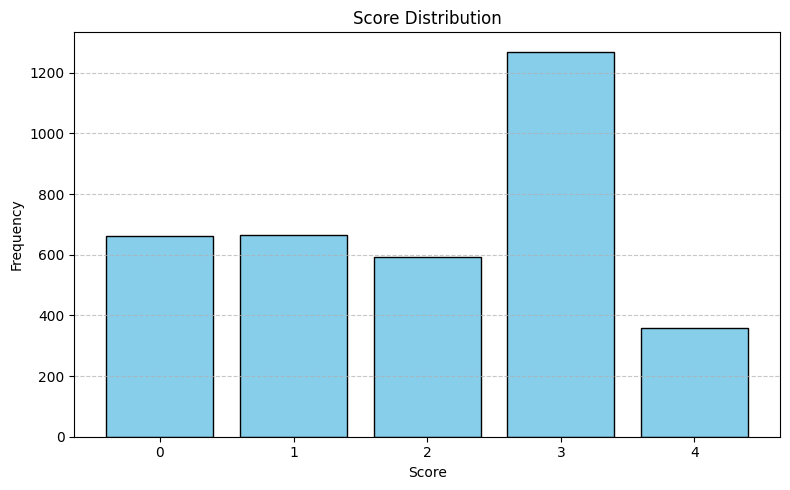

In [ ]:

def plot_score_distribution(df):
    score_counts = df['score'].value_counts().sort_index()
    plt.figure(figsize=(8, 5))
    plt.bar(score_counts.index, score_counts.values, color='skyblue', edgecolor='black')
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.title("Score Distribution")
    plt.xticks(score_counts.index)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_score_distribution(data)


The data generated from claude is not baised to any score so no need of startfies sampling

In [ ]:

#الي نسي يطلع الايبمورتس فوق يطلعهم مكسل
def format_instruction(row):
    instruction = f"""You are an expert examiner. Your task is to evaluate a student's answer and give a score from 0 to 4 and a rationale based on a question, a reference answer, and a detailed mark scheme.

Question:
{row['question']}

Reference Answer:
{row['reference_answer']}

Student Answer:
{row['student_answer']}

Marking Scheme (0–4 points):
{json.dumps(row['mark_scheme'], indent=2) if isinstance(row['mark_scheme'], dict) else row['mark_scheme']}

Instructions:
- Grade the student answer on a scale from 0 to 4 based strictly on the mark scheme.
- For each criterion, assess whether it was satisfied.
- Provide a detailed and objective rationale explaining the score and make it related to the question and the answer contextually.
- Be concise, specific, and professional in your explanation."""

    response = f"Score: {row['score']}\nRationale: {row['rationale']}"
    return {
        "instruction": instruction.strip(),
        "output": response.strip()
    }

#format it
formatted_data = data.apply(format_instruction, axis=1).tolist()
dataset = Dataset.from_pandas(pd.DataFrame(formatted_data))

# split
dataset_split = dataset.train_test_split(test_size=0.1, seed=3407)
test_set = dataset_split['test']
remaining_set = dataset_split['train']

final_split = remaining_set.train_test_split(test_size=0.1111, seed=3407)
train_set = final_split['train']
val_set = final_split['test']

dataset_dict = DatasetDict({
    "train": train_set,
    "validation": val_set,
    "test": test_set
})

print(f"Train set: {len(train_set)} examples")
print(f"Validation set: {len(val_set)} examples")
print(f"Test set: {len(test_set)} examples")


Train set: 2838 examples
Validation set: 355 examples
Test set: 355 examples


In [9]:
def formatting_prompts_func(examples):
    """Format examples for Unsloth SFTTrainer - return list of strings"""
    instructions = examples["instruction"]
    outputs = examples["output"]
    texts = []

    for instruction, output in zip(instructions, outputs):
        text = f"<s>[INST] {instruction} [/INST] {output}</s>"
        texts.append(text)

    return texts

In [10]:
# Set up Environment Variables
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # To avoid warnings
MAX_SEQ_LENGTH = 2048
MODEL_NAME = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"
dtype = torch.float16
load_in_4bit = True

In [11]:
# TEAM MEMBERS PLEASE DONT USE THIS METHOD LOAD IT IN 4 BIT (FASTER)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# Initialize with Unsloth for faster fine-tuning
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    load_in_4bit=load_in_4bit,
    dtype=dtype,
)

# Configure the tokenizer
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


==((====))==  Unsloth 2025.5.9: Fast Mistral patching. Transformers: 4.52.4. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

In [12]:
model = FastLanguageModel.for_inference(model)

In [13]:
model = FastLanguageModel.get_peft_model(
    model,
    r=32,
    lora_alpha=32,
    lora_dropout=0.0,  #cant do more because of unsloth
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
    use_gradient_checkpointing=True,
    random_state=42,
)


Unsloth 2025.5.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [14]:
model._flag_for_generation = True


In [15]:
training_arguments = TrainingArguments(
    output_dir="./results",
    max_steps=250,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    optim="adamw_8bit",
    save_steps=200,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    max_grad_norm=1.0,
    warmup_steps=5,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="none",
    eval_strategy="steps",
    eval_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=False,  # disable for speed
    dataloader_pin_memory=False,
    remove_unused_columns=True,
    dataloader_num_workers=0,  #imp for colab
)


In [16]:
# Cell 8: Training arguments optimized for T4 GPU

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
# Cell 9: Initialize SFTTrainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_set,
    eval_dataset=val_set,
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LENGTH,
    args=training_arguments,
    formatting_func=formatting_prompts_func,
    packing=False,
)

# Cell 10: Start training
print("Starting training...")
trainer.train()

# Cell 11: Save the model
trainer.save_model("./essay-grader-model")
tokenizer.save_pretrained("./essay-grader-model")


Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"]:   0%|          | 0/2838 [00:00<?, ? examples/s]

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"]:   0%|          | 0/355 [00:00<?, ? examples/s]

Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,838 | Num Epochs = 2 | Total steps = 250
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 83,886,080/7,000,000,000 (1.20% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
10,1.213900,0.645922
20,0.586400,0.579968
30,0.489700,0.518369
40,0.399800,0.488183
50,0.485200,0.483200
60,0.502900,0.457088
70,0.387800,0.439564
80,0.348700,0.428890
90,0.364300,0.398836
100,0.476700,0.409129


Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step,Training Loss,Validation Loss
10,1.213900,0.645922
20,0.586400,0.579968
30,0.489700,0.518369
40,0.399800,0.488183
50,0.485200,0.483200
60,0.502900,0.457088
70,0.387800,0.439564
80,0.348700,0.428890
90,0.364300,0.398836
100,0.476700,0.409129


('./essay-grader-model/tokenizer_config.json',
 './essay-grader-model/special_tokens_map.json',
 './essay-grader-model/chat_template.jinja',
 './essay-grader-model/tokenizer.model',
 './essay-grader-model/added_tokens.json',
 './essay-grader-model/tokenizer.json')

In [17]:

def test_model(question, reference_answer, student_answer, mark_scheme):
    """Test the trained model with a sample"""
    FastLanguageModel.for_inference(model)  # Enable native 2x faster inference

    instruction = f"""You are an expert examiner. Your task is to evaluate a student's answer and give a score from 0 to 4 and a rationale based on a question, a reference answer, and a detailed mark scheme.

Question:
{question}

Reference Answer:
{reference_answer}

Student Answer:
{student_answer}

Marking Scheme (0–4 points):
{mark_scheme}

Instructions:
- Grade the student answer on a scale from 0 to 4 based strictly on the mark scheme.
- For each criterion, assess whether it was satisfied.
- Provide a detailed and objective rationale explaining the score and make it related to the question and the answer contextually.
- Always provide a score of 4 even if you face more than 5 points in mark scheme  try to combine everything and give a score of 4 the same goes when less than 4.
- Be concise, specific, and professional in your explanation."""


    inputs = tokenizer([f"<s>[INST] {instruction} [/INST]"], return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            use_cache=True,
            do_sample=True,
            temperature=0.1,
            top_p=0.9,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.split("[/INST]")[-1].strip()

sample_question = "What are the Five Pillars of Islam?"

sample_reference = (
    "The Five Pillars of Islam are the core acts of worship and practice in Islam. "
    "They include Shahada (faith), Salah (prayer), Zakat (charity), Sawm (fasting during Ramadan), "
    "and Hajj (pilgrimage to Mecca)."
)

sample_student = (
    "The Five Pillars are believing in Allah, praying five times a day, giving charity, fasting in Ramadan, "
    "and visiting Mecca."
)

sample_scheme = (
    "1: Mentions Shahada or belief in Allah, "
    "2: Mentions Salah or prayer, "

)




In [18]:
result = test_model(sample_question, sample_reference, sample_student, sample_scheme)
print(result)

Score: 4
Rationale: Mentions Shahada (belief in Allah - point 1) and Salah (prayer - point 2). Also mentions Zakat (charity), Sawm (fasting), and Hajj (pilgrimage) - all other pillars. Covers all five pillars.


In [19]:
from torch.nn import CrossEntropyLoss

# calculate Perplexity on the test set
model.eval()
eval_loss = 0.0
num_batches = 0
criterion = CrossEntropyLoss()

for example in test_set:
    # format the example as a full text string that the model expects
    text = f"<s>[INST] {example['instruction']} [/INST] {example['output']}</s>"

    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=MAX_SEQ_LENGTH).to("cuda")

    # shift the labels to the left by one
    # the input is shifted for the loss calculation
    labels = inputs.input_ids.clone()
    labels[labels == tokenizer.pad_token_id] = -100 # Ignore padding tokens in loss

    with torch.no_grad():
        outputs = model(**inputs)

    # Calculate the loss
    # when used with model outputs that include logits.
    # we need to manually calculate loss to get it per token for perplexity.
    logits = outputs.logits

    # shift tokens to the right to get the labels aligned with the logits
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # flatten the tokens
    loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

    eval_loss += loss.item()
    num_batches += 1

average_loss = eval_loss / num_batches
perplexity = torch.exp(torch.tensor(average_loss))

print(f"Average Loss on Test Set: {average_loss:.4f}")
print(f"Perplexity on Test Set: {perplexity.item():.4f}")



Average Loss on Test Set: 0.3761
Perplexity on Test Set: 1.4565


In [20]:
SAVE_DIR = "/content/drive/MyDrive/modelfolder/final_model"


import os
os.makedirs(SAVE_DIR, exist_ok=True)

model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print(f"Model and tokenizer saved to: {SAVE_DIR}")

Model and tokenizer saved to: /content/drive/MyDrive/modelfolder/final_model
